In [1]:
#import everything necessary for eda

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import warnings
warnings.filterwarnings('ignore')

sys.path.append('../helpers/')

from data import Database
from utils import Helpers

In [2]:
db = Database(host="localhost", database="telecom", user="postgres", password="heisenberg")
df = db.read_table_to_dataframe('xdr_data')
df.head()

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,1.311448e+19,4/4/2019 12:01,770.0,4/25/2019 14:35,662.0,1823652.0,2.082014e+14,3.366496e+10,3.552121e+13,9.16456699548519E+015,...,15854611.0,2501332.0,8198936.0,9656251.0,278082303.0,14344150.0,171744450.0,8814393.0,36749741.0,308879636.0
1,1.311448e+19,4/9/2019 13:04,235.0,4/25/2019 8:15,606.0,1365104.0,2.082019e+14,3.368185e+10,3.579401e+13,L77566A,...,20247395.0,19111729.0,18338413.0,17227132.0,608750074.0,1170709.0,526904238.0,15055145.0,53800391.0,653384965.0
2,1.311448e+19,4/9/2019 17:42,1.0,4/25/2019 11:58,652.0,1361762.0,2.082003e+14,3.376063e+10,3.528151e+13,D42335A,...,19725661.0,14699576.0,17587794.0,6163408.0,229584621.0,395630.0,410692588.0,4215763.0,27883638.0,279807335.0
3,1.311448e+19,4/10/2019 0:31,486.0,4/25/2019 7:36,171.0,1321509.0,2.082014e+14,3.375034e+10,3.535661e+13,T21824A,...,21388122.0,15146643.0,13994646.0,1097942.0,799538153.0,10849722.0,749039933.0,12797283.0,43324218.0,846028530.0
4,1.311448e+19,4/12/2019 20:10,565.0,4/25/2019 10:40,954.0,1089009.0,2.082014e+14,3.369980e+10,3.540701e+13,D88865A,...,15259380.0,18962873.0,17124581.0,415218.0,527707248.0,3529801.0,550709500.0,13910322.0,38542814.0,569138589.0


In [3]:
#for all the missing values, if they are float, replace the missing values with the mean of the column's values

for column in df.columns:
    if df[column].dtype == 'float64' and df[column].isnull().any():
        mean_value = df[column].mean()
        df[column].fillna(mean_value, inplace=True)
        
df.isnull().sum()
no_null_df = df
no_null_df.isnull().sum()


Bearer Id                                      0
Start                                          1
Start ms                                       0
End                                            1
End ms                                         0
Dur. (ms)                                      0
IMSI                                           0
MSISDN/Number                                  0
IMEI                                           0
Last Location Name                          1153
Avg RTT DL (ms)                                0
Avg RTT UL (ms)                                0
Avg Bearer TP DL (kbps)                        0
Avg Bearer TP UL (kbps)                        0
TCP DL Retrans. Vol (Bytes)                    0
TCP UL Retrans. Vol (Bytes)                    0
DL TP < 50 Kbps (%)                            0
50 Kbps < DL TP < 250 Kbps (%)                 0
250 Kbps < DL TP < 1 Mbps (%)                  0
DL TP > 1 Mbps (%)                             0
UL TP < 10 Kbps (%) 

## Task 4.1

Aggregate, per customer, the following information (treat missing & outliers by replacing by the mean or the mode of the corresponding variable):
Average TCP retransmission
Average RTT
Handset type
Average throughput



In [4]:
task_4_1_columns = [
    'MSISDN/Number',
    'Avg RTT DL (ms)',
    'Avg RTT UL (ms)',
    'Handset Type',
    'Avg Bearer TP DL (kbps)',
    'Avg Bearer TP UL (kbps)',
    'TCP DL Retrans. Vol (Bytes)',
    'TCP UL Retrans. Vol (Bytes)'
]

In [5]:
#Average TCP retransmission in all the data

#first let me select the relevant data and put it in a datafram

task4_1_data = no_null_df[task_4_1_columns]
task4_1_data.isnull().sum()
#we got 0 missing values in the float64 dtype
#so now we do average tcp retransmission 

tcp_retransmission = (
    task4_1_data.groupby('MSISDN/Number')
    .agg({'TCP DL Retrans. Vol (Bytes)': 'mean', 'TCP UL Retrans. Vol (Bytes)': 'mean'})
    .reset_index()
)

#rename the columns
tcp_retransmission.columns = ['MSISDN/Number', 'Avg_TCP_DL_Retrans (MB)', 'Avg_TCP_UL_Retrans (MB)']
tcp_retransmission /= (1024 * 1024)
tcp_retransmission.head()

,MSISDN/Number,Avg_TCP_DL_Retrans (MB),Avg_TCP_UL_Retrans (MB)
0,32044.412348,19.845881,0.724467
1,32044.412378,19.845881,0.724467
2,32044.413100,19.845881,0.724467
3,32044.418175,0.001017,0.724467
4,32044.418923,14.381191,0.372343


And now we do average RTT

In [6]:
#group by msisdn

rtt_data = no_null_df[task_4_1_columns]

rtt_data = (
    task4_1_data.groupby('MSISDN/Number')
    .agg({'Avg RTT DL (ms)': 'mean', 'Avg RTT UL (ms)': 'mean'})
    .reset_index()
)

rtt_data.columns = ['MSISDN/Number', 'Avg_RTT_DL (ms)', 'Avg_RTT_UL (ms)']
rtt_data.head()

,MSISDN/Number,Avg_RTT_DL (ms),Avg_RTT_UL (ms)
0,3.360100e+10,46.000000,0.000000
1,3.360100e+10,30.000000,1.000000
2,3.360100e+10,109.795706,17.662883
3,3.360101e+10,69.000000,15.000000
4,3.360101e+10,57.000000,2.500000


And now for handset type aggregation. We will use the handset with a mod of 0 to fill in the missing handset types and then  

In [7]:
most_freq = task4_1_data['Handset Type'].mode()[0]

task4_1_data['Handset Type'].fillna(most_freq, inplace=True)

#now group by msisdn number
handset = task4_1_data.groupby('MSISDN/Number')['Handset Type'].agg(lambda x: x.mode()[0]).reset_index()
handset.columns = ['MSISDN/Number', 'Most Used Handset Type']
handset.head()


,MSISDN/Number,Most Used Handset Type
0,3.360100e+10,Huawei P20 Lite Huawei Nova 3E
1,3.360100e+10,Apple iPhone 7 (A1778)
2,3.360100e+10,undefined
3,3.360101e+10,Apple iPhone 5S (A1457)
4,3.360101e+10,Apple iPhone Se (A1723)


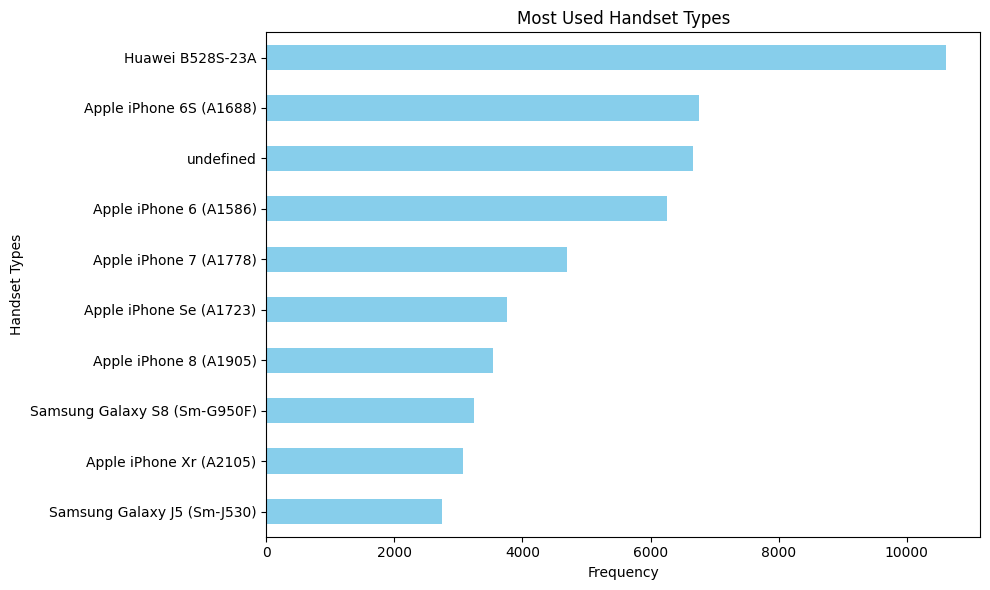

In [8]:
import matplotlib.pyplot as plt

# Assuming handset_data['Most Used Handset Type'] contains the handset types
handset_counts = handset['Most Used Handset Type'].value_counts().nlargest(10)

plt.figure(figsize=(10, 6))
handset_counts.sort_values().plot(kind='barh', color='skyblue')  # Horizontal bar chart
plt.title('Most Used Handset Types')
plt.xlabel('Frequency')
plt.ylabel('Handset Types')
plt.tight_layout()
plt.show()


Came to decide that "undefined" is something purposely set by the company and not something thatt is null or missing

In [9]:
handset['Most Used Handset Type'].value_counts()

Most Used Handset Type
Huawei B528S-23A                    10616
Apple iPhone 6S (A1688)              6759
undefined                            6669
Apple iPhone 6 (A1586)               6260
Apple iPhone 7 (A1778)               4699
                                    ...  
Wiko Global Sasu Wiko Highway 4G        1
Archos Sa Core 70 3G                    1
Logicom Sa Logicom Id Bot 53+           1
Htc 2Q5W100                             1
Quectel Wireless. Quectel Ec21-E        1
Name: count, Length: 1394, dtype: int64

And now the final task of 4.1: Throughput 


In [10]:
throughput_df = task4_1_data[['Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)']]
throughput_df['Avg Throughput (kbps)'] = (throughput_df['Avg Bearer TP DL (kbps)'] + throughput_df['Avg Bearer TP UL (kbps)']) / 2
# throughput_df['Avg Throughput (kbps)'] /= (1024 * 1024)
throughput_df

,Avg Bearer TP DL (kbps),Avg Bearer TP UL (kbps),Avg Throughput (kbps)
0,23.000000,44.000000,33.500000
1,16.000000,26.000000,21.000000
2,6.000000,9.000000,7.500000
3,44.000000,44.000000,44.000000
4,6.000000,9.000000,7.500000
...,...,...,...
149996,52.000000,65.000000,58.500000
149997,23.000000,54.000000,38.500000
149998,43.000000,47.000000,45.000000
149999,34.000000,37.000000,35.500000


And Now task 4.2

In [11]:
#top 10 tcp values

top_10_tcp = tcp_retransmission.nlargest(10, 'Avg_TCP_DL_Retrans (MB)')
top_10_tcp

,MSISDN/Number,Avg_TCP_DL_Retrans (MB),Avg_TCP_UL_Retrans (MB)
85785,32137.466397,4090.774156,11.434401
32273,32099.443520,4089.413036,0.057693
58026,32105.357340,4070.693966,0.205378
31942,32099.374041,4057.544543,0.015083
62049,32106.519208,4016.102807,0.065615
70079,32109.039708,3973.570808,0.003804
43629,32101.922377,3939.672239,6.572703
48341,32102.963169,3926.995676,0.049167
64113,32107.185584,3784.248755,0.045942
98211,32198.565863,3609.938387,1.503161


In [12]:
#bottom 10 tcp values

bottom_10_tcp = tcp_retransmission.nsmallest(10, 'Avg_TCP_DL_Retrans (MB)')
bottom_10_tcp

,MSISDN/Number,Avg_TCP_DL_Retrans (MB),Avg_TCP_UL_Retrans (MB)
56622,32105.002936,0.000002,0.020558
95322,32197.517018,0.000002,0.724467
71705,32109.555278,0.000004,0.724467
71778,32109.573715,0.000004,0.005051
87156,32137.873641,0.000004,0.724467
87348,32137.928915,0.000004,0.724467
95213,32197.482033,0.000004,0.724467
95331,32197.518213,0.000004,0.001257
95774,32197.589598,0.000004,0.724467
100616,32199.800634,0.000004,0.091042


In [13]:
top_10_rtt = rtt_data.nsmallest(10, 'Avg_RTT_DL (ms)')
top_10_rtt


,MSISDN/Number,Avg_RTT_DL (ms),Avg_RTT_UL (ms)
28878,3.365298e+10,0.0,0.0
40873,3.366064e+10,0.0,29.0
44748,3.366158e+10,0.0,0.0
66098,3.366748e+10,0.0,785.0
88903,3.369954e+10,0.0,33.0
98541,3.376275e+10,0.0,38.0
39066,3.366020e+10,2.0,0.0
83396,3.369505e+10,4.0,0.0
36039,3.365949e+10,5.0,0.0
106569,3.378806e+10,5.0,25.0


In [14]:
bottom_10_rtt = rtt_data.nlargest(10, 'Avg_RTT_DL (ms)')
bottom_10_rtt

,MSISDN/Number,Avg_RTT_DL (ms),Avg_RTT_UL (ms)
47983,3.366232e+10,96923.0,1.0
80249,3.368369e+10,54847.0,1.0
41944,3.366087e+10,32333.0,2.0
93844,3.376094e+10,26971.0,307.0
1713,3.360679e+10,26250.0,50.0
74240,3.367182e+10,25602.0,113.0
104325,3.378187e+10,25374.0,14.0
105752,3.378401e+10,24733.0,5.0
85683,3.369855e+10,22961.5,49.0
15409,3.362963e+10,20979.0,1.0


In [15]:
top_10_throughput = throughput_df.nlargest(10, 'Avg Throughput (kbps)')
top_10_throughput

,Avg Bearer TP DL (kbps),Avg Bearer TP UL (kbps),Avg Throughput (kbps)
120890,378160.0,4102.0,191131.0
143670,299002.0,14242.0,156622.0
141262,299257.0,5042.0,152149.5
91313,246514.0,54032.0,150273.0
116807,245347.0,38584.0,141965.5
141458,238197.0,42947.0,140572.0
149617,276040.0,1112.0,138576.0
92193,269362.0,6843.0,138102.5
116565,263047.0,11005.0,137026.0
117791,266332.0,3556.0,134944.0


In [16]:
bottom_10_throughput = throughput_df.nsmallest(10, 'Avg Throughput (kbps)')
bottom_10_throughput

,Avg Bearer TP DL (kbps),Avg Bearer TP UL (kbps),Avg Throughput (kbps)
149,0.0,0.0,0.0
364,0.0,0.0,0.0
618,0.0,0.0,0.0
756,0.0,0.0,0.0
1818,0.0,0.0,0.0
2489,0.0,0.0,0.0
3935,0.0,0.0,0.0
4166,0.0,0.0,0.0
4853,0.0,0.0,0.0
5821,0.0,0.0,0.0


### Task 4.3

Handset type with the most throughput 

In [17]:
avg_tp_per_handset = task4_1_data.groupby('Handset Type')[['Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)']].mean()
avg_tp_per_handset


,Avg Bearer TP DL (kbps),Avg Bearer TP UL (kbps)
Handset Type,,
A-Link Telecom I. Cubot A5,23184.000000,326.00000
A-Link Telecom I. Cubot Note Plus,6527.000000,172.00000
A-Link Telecom I. Cubot Note S,8515.000000,422.00000
A-Link Telecom I. Cubot Nova,55667.000000,550.00000
A-Link Telecom I. Cubot Power,69126.000000,342.00000
...,...,...
Zte Zte Blade C2 Smartphone Android By Sfr Startrail 4 Zte Blade Flex T809 Zte T809,44.500000,13.50000
Zyxel Communicat. Lte7460,39741.000000,22215.00000
Zyxel Communicat. Sbg3600,82818.000000,14533.00000


In [18]:
#Top 10 handsets with the most throughput

avg_tp_per_handset.nlargest(10, 'Avg Bearer TP DL (kbps)')

,Avg Bearer TP DL (kbps),Avg Bearer TP UL (kbps)
Handset Type,,
New-Bund Technol. Mix 2,104669.000000,542.000000
Lg G6+,97747.000000,2388.000000
Huawei B715S-23C,92075.692308,16918.538462
Huawei Y9 2019,90557.000000,1182.000000
Spa Condor Elect. Allure M2,83294.500000,1017.000000
Zyxel Communicat. Sbg3600,82818.000000,14533.000000
Xiaomi Communica. M1902F1G,81646.666667,3967.000000
Huawei Pele,76474.000000,1907.000000
Shenzhen Leagoo. Leagoo S8,74086.000000,2022.000000


In [19]:
#These almost have no internet
avg_tp_per_handset.nsmallest(10, 'Avg Bearer TP DL (kbps)')

,Avg Bearer TP DL (kbps),Avg Bearer TP UL (kbps)
Handset Type,,
Acer Liquid M220,0.0,34.0
Archos Sa Core 70 3G,0.0,592.0
Archos Sa Sense 101X,0.0,497.0
Htc Desire,0.0,64.0
Lg Lg-T385,0.0,0.0
Logicom Sa L-Ement 400,0.0,412.0
Mobiwire Sas Mobiwire Auriga,0.0,9.0
Rim 8520,0.0,3.0
Rim 9780 Rcm72Uw Rcm73Uw (Fdd I Ii V Vi) (Generic),0.0,3.0


In [20]:
avg_tcp_ret_p_handset = task4_1_data.groupby('Handset Type')[['TCP DL Retrans. Vol (Bytes)']].mean()
avg_tcp_ret_p_handset /= (1024 * 1024)
avg_tcp_ret_p_handset.nlargest(10, 'TCP DL Retrans. Vol (Bytes)')

,TCP DL Retrans. Vol (Bytes)
Handset Type,
Lg Lg-H635,869.550131
Huawei Bln-Al10,313.820428
Asustek Asus Zenfone Selfie Zd551Kl,304.177629
Samsung Galaxy Tab S3 (Sm-T825),193.242757
Huawei E5776S-32,160.209609
Apple iPad Pro (A1652),121.529078
Samsung Galaxy J8 2018,110.390326
Dynamic Tech Hol. D-Mobile I3 I5 I7 I8 I9,98.184990
Xiaomi Communica. Mi 6,71.670655


In [21]:
numeric_columns = [
    'Avg RTT DL (ms)',
    'Avg RTT UL (ms)',
    'Avg Bearer TP DL (kbps)',
    'Avg Bearer TP UL (kbps)',
    'TCP DL Retrans. Vol (Bytes)',
    'TCP UL Retrans. Vol (Bytes)'
]

numeric_data = no_null_df[['MSISDN/Number'] + numeric_columns]

# Grouping by 'MSISDN/Number' and computing mean values for numeric columns
agg_data = numeric_data.groupby('MSISDN/Number').agg('mean').reset_index()

# Displaying the aggregated DataFrame
agg_data.head()

,MSISDN/Number,Avg RTT DL (ms),Avg RTT UL (ms),Avg Bearer TP DL (kbps),Avg Bearer TP UL (kbps),TCP DL Retrans. Vol (Bytes),TCP UL Retrans. Vol (Bytes)
0,3.360100e+10,46.000000,0.000000,37.0,39.0,2.080991e+07,759658.664811
1,3.360100e+10,30.000000,1.000000,48.0,51.0,2.080991e+07,759658.664811
2,3.360100e+10,109.795706,17.662883,48.0,49.0,2.080991e+07,759658.664811
3,3.360101e+10,69.000000,15.000000,204.0,44.0,1.066000e+03,759658.664811
4,3.360101e+10,57.000000,2.500000,20197.5,8224.5,1.507977e+07,390430.332406


Performing K-means on aggregated data

In [22]:
columns_for_kmeans = [
    'Avg RTT DL (ms)',
    'Avg RTT UL (ms)',
    'Avg Bearer TP DL (kbps)',
    'Avg Bearer TP UL (kbps)',
    'TCP DL Retrans. Vol (Bytes)',
    'TCP UL Retrans. Vol (Bytes)'
]

result_clusters = Helpers.perform_kmeans(agg_data=agg_data, columns=columns_for_kmeans, n_clusters=3)
result_clusters.head()


,MSISDN/Number,Cluster
0,3.360100e+10,0
1,3.360100e+10,0
2,3.360100e+10,0
3,3.360101e+10,0
4,3.360101e+10,0


In [23]:
result_clusters['Cluster'].unique()

array([0, 1, 2], dtype=int32)

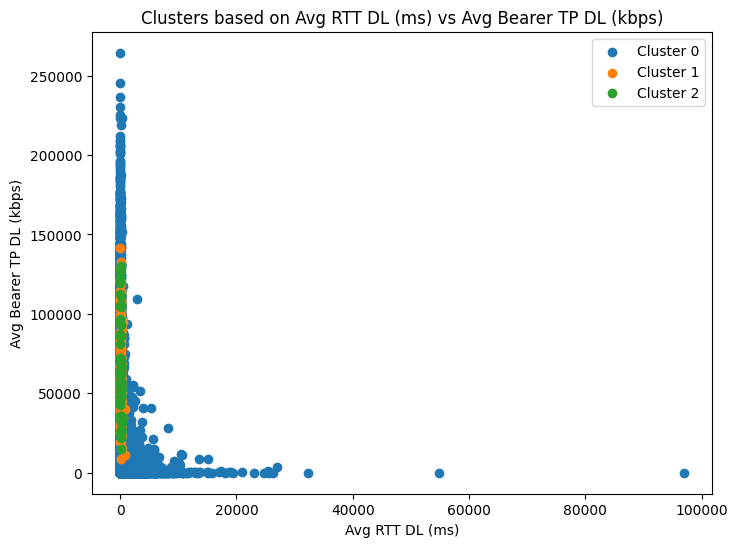

In [24]:
x_column = 'Avg RTT DL (ms)'  
y_column = 'Avg Bearer TP DL (kbps)'  
cluster_column = 'Cluster'  

Helpers.plot_clusters(agg_data, x_column, y_column, cluster_column)

In [ ]:
x_column = 'TCP DL Retrans. Vol '  
y_column = 'Avg Bearer TP DL (kbps)'  
cluster_column = 'Cluster'  

Helpers.plot_clusters(agg_data, x_column, y_column, cluster_column)